In [20]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [21]:
# Importing dependencies
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from math import sqrt
import datetime as dt
import time
import yfinance as yf
import tensorflow as tf
plt.style.use('ggplot')

### Data Preprocessing

In [22]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

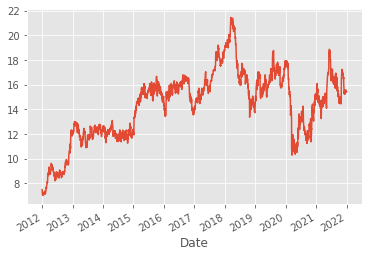

In [23]:
# Loading the dataset

df = yf.download(tickers='abev3.sa', start="2012-01-01", end="2021-12-31")
df.drop(df[df['Volume']==0].index, inplace = True)
df['Adj Close'].plot()

In [24]:
# Correlation matrix
df.corr()['Adj Close']

Open         0.876644
High         0.882871
Low          0.876364
Close        0.878957
Adj Close    1.000000
Volume       0.235908
Name: Adj Close, dtype: float64

In [25]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,10.890463,10.980400,10.746562,10.872475,7.493662,119582
2012-01-03,10.892461,10.946424,10.654626,10.748561,7.408257,2099952
2012-01-04,10.716583,10.748561,10.316860,10.498734,7.236069,989684
2012-01-05,10.362828,10.390808,10.194944,10.290878,7.092808,1077745
2012-01-06,10.288879,10.430781,10.206936,10.264896,7.074902,451312
...,...,...,...,...,...,...
2021-12-23,15.400000,15.670000,15.340000,15.550000,15.550000,10634700
2021-12-27,15.550000,15.650000,15.480000,15.530000,15.530000,8437200
2021-12-28,15.540000,15.570000,15.400000,15.520000,15.520000,7701300


In [26]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df.shape

count    2.464000e+03
mean     1.491285e+07
std      1.446563e+07
min      1.900000e+03
25%      7.422070e+06
50%      1.245780e+07
75%      1.971638e+07
max      2.876952e+08
Name: Volume, dtype: float64


(2464, 6)

In [27]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [28]:
# Função para transformar dados em sequencia do LSTM
def to_sequential_data(data, timesteps):
    x,y = [],[]
    for i in range(timesteps,data.shape[0]):
        x.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(x),np.array(y)

In [29]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    
    X_train,Y_train = to_sequential_data(train, timesteps)
    X_val,Y_val = to_sequential_data(val, timesteps)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(SimpleRNN(hl[i],activation = 'relu',return_sequences = True))
    model.add(SimpleRNN(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [30]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mae, mse, rmse, r2, Y_test, Y_hat

In [31]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Dia')
    plt.ylabel('Preço normalizado')
    #plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Atual','Predito'],loc = 'lower right')
    plt.show()

In [32]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

In [33]:
# Extracting the series
features = ['Adj Close', 'Open', 'Low', 'High']
series = df[features] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(2464, 4)
            Adj Close   Open    Low   High
Date                                      
2021-12-23      15.55  15.40  15.34  15.67
2021-12-27      15.53  15.55  15.48  15.65
2021-12-28      15.52  15.54  15.40  15.57
2021-12-29      15.45  15.55  15.34  15.56
2021-12-30      15.42  15.58  15.39  15.59


In [34]:
# Train Val Test Split
qt_teste = 300

train_data =  series.iloc[:-(qt_teste*2),]
val_data = series.iloc[-(qt_teste*2):-qt_teste,]
test_data = series.iloc[-qt_teste:]

print(train_data.shape,val_data.shape,test_data.shape)

(1864, 4) (300, 4) (300, 4)


In [35]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1864, 4) (300, 4) (300, 4)


In [54]:
timesteps = 20
hl = [35,25]
lr = 1e-4
batch_size = 64
num_epochs = 100

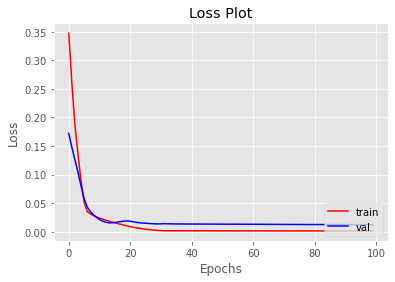

In [55]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MAE = 0.05379249269271504
MSE = 0.004092405679905871
RMSE = 0.06397191321123569
R2-Score = 0.41167956220122826


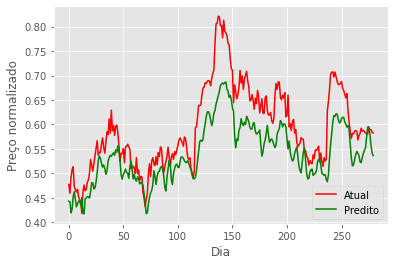

In [57]:
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MAE = {}'.format(mae))
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)

In [58]:
# Save a model
model.save('RNN-M ABEV3')
del model  #Deletes the model
# Load a model
model = load_model('RNN-M ABEV3')

INFO:tensorflow:Assets written to: RNN-M ABEV3\assets


## Cross Validation

In [59]:
timesteps = 20
hl = [35,25]
lr = 1e-4
batch_size = 64
num_epochs = 50

In [60]:
# Extracting the series
series = df[features] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(2464, 4)
            Adj Close   Open    Low   High
Date                                      
2021-12-23      15.55  15.40  15.34  15.67
2021-12-27      15.53  15.55  15.48  15.65
2021-12-28      15.52  15.54  15.40  15.57
2021-12-29      15.45  15.55  15.34  15.56
2021-12-30      15.42  15.58  15.39  15.59


In [61]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:series.shape[0]])
series

array([[0.03249235, 0.0491312 , 0.04497571, 0.05084863],
       [0.0265673 , 0.04927193, 0.03836588, 0.04847382],
       [0.01462169, 0.03688362, 0.01408193, 0.03464414],
       ...,
       [0.58932491, 0.37663131, 0.37953862, 0.37164047],
       [0.58446857, 0.3773357 , 0.37522491, 0.37094157],
       [0.58238732, 0.3794488 , 0.37881972, 0.37303841]])

### Split I

In [62]:
#Splitting the data for initial model creation
splits = 5
split_size = 300

cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()

Split 1
MAE = 0.03078025152669903
MSE = 0.0013310364531302385
RMSE = 0.03648337228286659
R-Squared Score = 0.3987741451384511


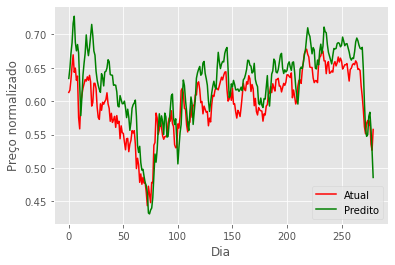

In [63]:
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,shuffle = False)
end = time.time()   

train_loss['Split1'] =  history.history['loss']
val_loss['Split1'] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-RNN-Split1.h5")

### Split II

Split 2
MAE = 0.05937866426377839
MSE = 0.0038715819199967045
RMSE = 0.062222037253666845
R-Squared Score = 0.6839575124567968


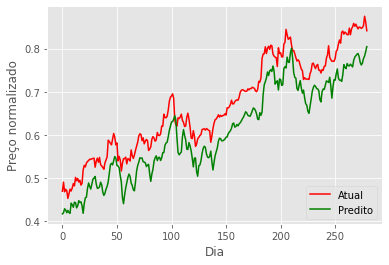

In [64]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-RNN-Split2.h5")

### Split III

Split 3
MAE = 0.03560533780273645
MSE = 0.0016713057633206219
RMSE = 0.04088160666266215
R-Squared Score = 0.9137966555070909


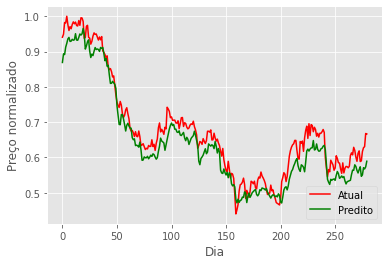

In [65]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-RNN-Split3.h5")

### Split IV

Split 4
MAE = 0.08979011199983845
MSE = 0.01013883105474269
RMSE = 0.1006917625962655
R-Squared Score = 0.656329079568377


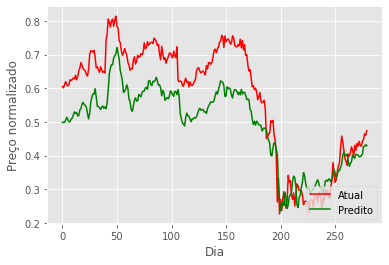

In [66]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-RNN-Split4.h5")

### Split V

Split 5
MAE = 0.07208620846848078
MSE = 0.007172036070689723
RMSE = 0.08468787440176853
R-Squared Score = 0.5559971994601842


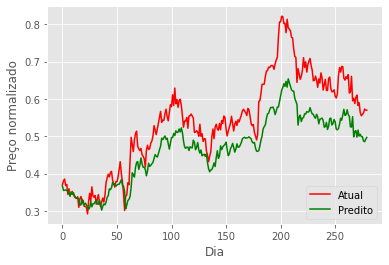

In [67]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-RNN-Split5.h5")

In [68]:
CV_temp = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MAE = {}".format(CV_temp['MAE'].mean()))
print("Avg. MSE = {}".format(CV_temp['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_temp['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_temp['R2_Score'].mean()))
cross_val_results.append([CV_temp['MAE'].mean(), CV_temp['MSE'].mean(),CV_temp['RMSE'].mean(),CV_temp['R2_Score'].mean()])
cross_val_results.append([CV_temp['MAE'].std(), CV_temp['MSE'].std(),CV_temp['RMSE'].std(),CV_temp['R2_Score'].std()])
CV_results = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score', 'Train_Time'])

Avg. MAE = 0.057528114812306616
Avg. MSE = 0.004836958252375996
Avg. RMSE = 0.06499333063944593
Avg. R2-score = 0.6417709184261801


In [69]:
CV_results.to_csv('RNN-M ABEV3.csv')
# train_loss.to_csv('MV3-GRU_CrossValidation_TrainLoss.csv')
# val_loss.to_csv('MV3-GRU_CrossValidation_ValLoss.csv')